# BUAI 435 Final Project: Option 1: Amazon Musical Instruments Sentiment Modeling
  
**Dataset:** `Amazon_Musical.csv`  
Dataset Relative Path: `data/Amazon_Musical.csv`  
Group Members: Ruihuang Yang, Srdjan Demonjic, Sonu Kumar, Kartheek Tadepalli  
CWRU NetIDs: rxy216, sxd1075, sxk2311, kxt405  
Due Date: 2025-12-02  

## 0. Set up & Data import

In [1]:
from __future__ import annotations

import json
import os
import random
import re
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import spacy
from spacy.language import Language


load_dotenv()
sns.set_theme(style="whitegrid", palette="deep")

SEED: int = 42
DEV_MODE: bool = True
DEV_SAMPLE_FRAC: float = 0.01
DATA_PATH: Path = Path("data/Amazon_Musical.csv")
OUTPUTS_DIR: Path = Path("outputs")
FIGURES_DIR: Path = OUTPUTS_DIR / "figures"
TABLES_DIR: Path = OUTPUTS_DIR / "tables"
INTERMEDIATE_DIR: Path = OUTPUTS_DIR / "intermediate"
SPACY_MODEL_NAME: str = "en_core_web_md"
MIN_TOKENS: int = 3
MANUAL_LABEL_SAMPLE_SIZE: int = 300
N_TOPICS: int = 10
TOP_TERMS_PER_TOPIC: int = 12
TOPIC_EXEMPLARS: int = 4
SPACY_PIPE_BATCH_SIZE: int = 128
SPACY_PIPE_N_PROCS: int = 4


def set_global_seed(seed: int = SEED) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)


def ensure_output_dirs() -> None:
    for path in (OUTPUTS_DIR, FIGURES_DIR, TABLES_DIR, INTERMEDIATE_DIR):
        path.mkdir(parents=True, exist_ok=True)


def save_table(df: pd.DataFrame, filename: str) -> None:
    target = TABLES_DIR / filename
    df.to_csv(target, index=True)
    print(f"[TABLE] Saved and displaying '{filename}' from {target}")
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(df)


def save_json(payload: Dict, filename: str) -> None:
    target = TABLES_DIR / filename
    with target.open("w", encoding="utf-8") as fp:
        json.dump(payload, fp, indent=2)


def save_and_show_figure(fig: plt.Figure, name: str) -> None:
    fig.tight_layout()
    save_path = FIGURES_DIR / f"{name}.png"
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def load_amazon_reviews(csv_path: Path = DATA_PATH) -> pd.DataFrame:
    dtypes = {
        "marketplace": "category",
        "customer_id": "string",
        "review_id": "string",
        "product_id": "string",
        "product_parent": "Int64",
        "product_title": "string",
        "product_category": "category",
        "star_rating": "Int64",
        "helpful_votes": "Int64",
        "total_votes": "Int64",
        "vine": "category",
        "verified_purchase": "category",
        "review_headline": "string",
        "review_body": "string",
    }
    df = pd.read_csv(
        csv_path,
        dtype=dtypes,
        parse_dates=["review_date"],
    )
    return df


def apply_dev_gate(df: pd.DataFrame) -> pd.DataFrame:
    if DEV_MODE:
        sample = df.sample(frac=DEV_SAMPLE_FRAC, random_state=SEED, replace=False)
        print(
            f"[DEV MODE] Using {len(sample):,} rows ({DEV_SAMPLE_FRAC:.0%}) "
            f"out of {len(df):,} total reviews."
        )
        return sample.reset_index(drop=True)
    print("[PROD MODE] Using the full dataset.")
    return df.reset_index(drop=True)


def summarize_missingness(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isna().mean().sort_values(ascending=False).to_frame("missing_pct")
    return missing


def run_initial_eda(df: pd.DataFrame) -> None:
    rating_counts = (
        df["star_rating"]
        .value_counts(dropna=False)
        .sort_index()
        .to_frame(name="count")
    )
    rating_counts["pct"] = rating_counts["count"] / rating_counts["count"].sum()
    save_table(rating_counts, "star_rating_distribution.csv")

    missing_summary = summarize_missingness(df)
    save_table(missing_summary, "missingness_summary.csv")

    example_reviews = df[
        ["review_id", "product_id", "star_rating", "review_headline", "review_body"]
    ].head(5)
    save_table(example_reviews, "example_raw_reviews.csv")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(
        x=rating_counts.index.astype(str),
        y="count",
        data=rating_counts,
        ax=ax,
    )
    ax.set_title("Star Rating Distribution (Development Sample)")
    ax.set_xlabel("Star Rating")
    ax.set_ylabel("Count")
    save_and_show_figure(fig, "eda_star_rating_distribution")

### 0.1 Initialize environment, directories, and load sampled dataset

Loading dataset...
[DEV MODE] Using 9,048 rows (1%) out of 904,765 total reviews.
[TABLE] Saved and displaying 'star_rating_distribution.csv' from outputs/tables/star_rating_distribution.csv
             count       pct
star_rating                 
1              672  0.074271
2              401  0.044319
3              664  0.073386
4             1594  0.176172
5             5717  0.631852
[TABLE] Saved and displaying 'missingness_summary.csv' from outputs/tables/missingness_summary.csv
                   missing_pct
review_body           0.000111
marketplace           0.000000
customer_id           0.000000
review_id             0.000000
product_id            0.000000
product_parent        0.000000
product_title         0.000000
product_category      0.000000
star_rating           0.000000
helpful_votes         0.000000
total_votes           0.000000
vine                  0.000000
verified_purchase     0.000000
review_headline       0.000000
review_date           0.000000
[TABLE] Sav

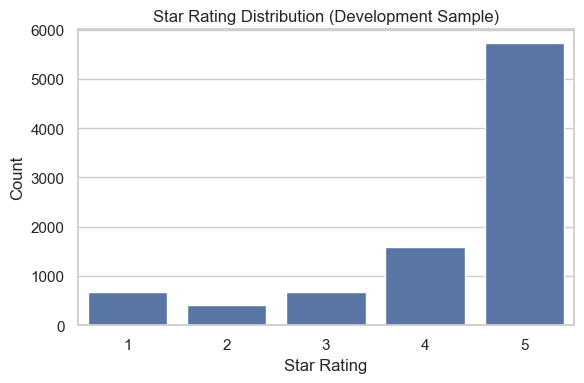

In [2]:
set_global_seed()
ensure_output_dirs()

print("Loading dataset...")
df_raw = load_amazon_reviews()
df_sampled = apply_dev_gate(df_raw)
run_initial_eda(df_sampled)

## 1. Text Preprocessing Helpers

In [3]:
HTML_PATTERN = re.compile(r"<.*?>")
URL_PATTERN = re.compile(r"http\S+|www\.\S+")
NON_ASCII_PATTERN = re.compile(r"[^\x00-\x7F]+")


def combine_headline_body(headline: str | float, body: str | float) -> str:
    headline = headline if isinstance(headline, str) else ""
    body = body if isinstance(body, str) else ""
    combined = " ".join(part.strip() for part in [headline, body] if part)
    return combined.strip()


def normalize_text(text: str) -> str:
    text = text.lower()
    text = HTML_PATTERN.sub(" ", text)
    text = URL_PATTERN.sub(" ", text)
    text = NON_ASCII_PATTERN.sub(" ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()


def load_spacy_model(model_name: str = SPACY_MODEL_NAME) -> Language:
    try:
        nlp = spacy.load(model_name, disable=["ner", "parser", "textcat"])
    except OSError:
        print(
            f"SpaCy model '{model_name}' is not downloaded. "
            "Run `python -m spacy download en_core_web_md`."
        )
        raise
    nlp.max_length = 2_000_000
    return nlp


def lemmatize_texts(texts: Sequence[str], nlp: Language) -> List[str]:
    processed: List[str] = []
    for doc in nlp.pipe(
        texts,
        batch_size=SPACY_PIPE_BATCH_SIZE,
        n_process=SPACY_PIPE_N_PROCS,
    ):
        tokens = [
            token.lemma_
            for token in doc
            if not token.is_stop
            and not token.is_punct
            and not token.is_space
            and len(token) > 2
        ]
        processed.append(" ".join(tokens))
    return processed


def preprocess_reviews(df: pd.DataFrame, nlp: Language) -> pd.DataFrame:
    df = df.copy()
    df["text_original"] = df.apply(
        lambda row: combine_headline_body(row["review_headline"], row["review_body"]),
        axis=1,
    )
    df = df[df["text_original"].str.len() > 0].copy()
    df["text_normalized"] = df["text_original"].apply(normalize_text)
    df["text_clean"] = lemmatize_texts(df["text_normalized"].tolist(), nlp)
    df["token_count"] = df["text_clean"].str.split().str.len()
    df = df[df["token_count"] >= MIN_TOKENS].copy()
    df = df.drop_duplicates(subset=["customer_id", "product_id", "text_clean"])

    before_after = df[
        ["review_id", "text_original", "text_clean"]
    ].sample(n=min(len(df), 5), random_state=SEED)
    save_table(before_after, "preprocessing_before_after_examples.csv")
    df.reset_index(drop=True, inplace=True)
    return df

### 1.1 Normalize and lemmatize reviews

In [4]:
print("Preprocessing text...")
nlp = load_spacy_model()
df_clean = preprocess_reviews(df_sampled, nlp)

Preprocessing text...
[TABLE] Saved and displaying 'preprocessing_before_after_examples.csv' from outputs/tables/preprocessing_before_after_examples.csv
           review_id                                      text_original  \
4112  R2N7I2KR88OY92  Best tuner I've had in years I tried two diffe...   
6104  R3BSS26R5BNC6Z  making music My grandson is really enjoying th...   
4885  R378R6T3HCSRKO  Great quality, quite small and unobtrusive Usi...   
8218   RMWW74Y80DPQD  Five Stars I have a couple of these I used out...   
5325  R1JHO708DYSY3S  Waste of money and time, do NOT buy! I am retu...   

                                             text_clean  
4112  good tuner year try different snark tuner accu...  
6104  make music grandson enjoy inch cymbal brother ...  
4885  great quality small unobtrusive desk web meeti...  
8218    star couple outside christmas talk neighborhood  
5325  waste money time buy return viola kind problem...  


## 2. Sentiment Labeling & Baselines

In [5]:
SENTIMENT_MAP = {
    1: "negative",
    2: "negative",
    3: "neutral",
    4: "positive",
    5: "positive",
}

POSITIVE_LEXICON = {
    "love",
    "good",
    "great",
    "excellent",
    "perfect",
    "amazing",
    "wonderful",
    "recommend",
    "awesome",
    "best",
    "favorite",
    "satisfied",
}
NEGATIVE_LEXICON = {
    "bad",
    "terrible",
    "awful",
    "horrible",
    "poor",
    "worst",
    "broken",
    "disappointed",
    "return",
    "refund",
    "noise",
    "noisy",
    "cheap",
    "defect",
}


def label_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["sentiment_label"] = df["star_rating"].map(SENTIMENT_MAP)
    df = df.dropna(subset=["sentiment_label"])
    return df


def export_manual_label_subset(df: pd.DataFrame) -> None:
    sample_size = min(MANUAL_LABEL_SAMPLE_SIZE, len(df))
    manual_subset = df.sample(sample_size, random_state=SEED)
    save_table(
        manual_subset[["review_id", "star_rating", "text_original"]],
        "manual_label_subset.csv",
    )


def majority_baseline(y_train: pd.Series, y_test: pd.Series) -> Dict[str, float]:
    majority_class = y_train.value_counts().idxmax()
    y_pred = np.full(shape=len(y_test), fill_value=majority_class, dtype=object)
    return {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "macro_f1": float(f1_score(y_test, y_pred, average="macro")),
        "weighted_f1": float(f1_score(y_test, y_pred, average="weighted")),
        "majority_class": majority_class,
    }


def lexicon_baseline(texts: Sequence[str], y_true: Sequence[str]) -> Dict[str, float]:
    predictions: List[str] = []
    for text in texts:
        tokens = text.split()
        score = sum(token in POSITIVE_LEXICON for token in tokens) - sum(
            token in NEGATIVE_LEXICON for token in tokens
        )
        if score > 0:
            predictions.append("positive")
        elif score < 0:
            predictions.append("negative")
        else:
            predictions.append("neutral")
    return {
        "accuracy": float(accuracy_score(y_true, predictions)),
        "macro_f1": float(f1_score(y_true, predictions, average="macro")),
        "weighted_f1": float(f1_score(y_true, predictions, average="weighted")),
    }

### 2.1 Apply sentiment labels and export manual audit data

In [6]:
print("Labeling sentiment...")
df_labeled = label_sentiment(df_clean)
export_manual_label_subset(df_labeled)

Labeling sentiment...
[TABLE] Saved and displaying 'manual_label_subset.csv' from outputs/tables/manual_label_subset.csv
           review_id  star_rating  \
3946  R2N7I2KR88OY92            5   
5867  R3BSS26R5BNC6Z            4   
4694  R378R6T3HCSRKO            5   
7883   RMWW74Y80DPQD            5   
5117  R1JHO708DYSY3S            1   
3544   RU6CMJBVX3SUT            1   
1775  R3216P24L5NH5Q            5   
1330  R1FQ4JM1P4ZQH5            5   
828   R30XGQLR3FZVHS            5   
3204  R39HFTB2S5DJW8            4   
14    R144Z7G4R8UHLV            5   
4947   RVT0I0O3KFBHF            5   
4559  R1PB4GU51JS3K4            5   
5192  R1E0UQ19UZNP8L            4   
4004  R2AWZPL75K8L4P            3   
346   R3EOI73JFPAQLF            5   
4834  R1X2G65U4CSWK9            5   
5494  R1Q513R2FW4CBK            4   
8403  R3SR2CCBTILI8Y            5   
1349   R5ZCF6WCQ54X1            2   
4522  R3BC7M9UR8CFIO            5   
8408  R314NFLCIKEU06            4   
7050  R10I7H3RI1EE27        

## 3. Feature Engineering & Modeling

In [7]:
def build_tfidf_features(
    train_texts: Sequence[str],
    test_texts: Sequence[str],
    max_features: int = 20_000,
) -> Tuple[TfidfVectorizer, np.ndarray, np.ndarray]:
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=max_features,
        min_df=5,
        max_df=0.9,
    )
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    feature_info = pd.DataFrame(
        {
            "n_features": [X_train.shape[1]],
            "train_rows": [X_train.shape[0]],
            "test_rows": [X_test.shape[0]],
        }
    )
    save_table(feature_info, "tfidf_feature_summary.csv")
    return vectorizer, X_train, X_test


def evaluate_model(
    y_true: Sequence[str],
    y_pred: Sequence[str],
    model_name: str,
) -> Dict[str, float]:
    report = classification_report(y_true, y_pred, output_dict=True)
    save_table(
        pd.DataFrame(report).transpose(),
        f"classification_report_{model_name}.csv",
    )

    cm = confusion_matrix(y_true, y_pred, labels=["negative", "neutral", "positive"])
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["neg", "neu", "pos"],
        yticklabels=["neg", "neu", "pos"],
        ax=ax,
    )
    ax.set_title(f"Confusion Matrix — {model_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    save_and_show_figure(fig, f"confusion_matrix_{model_name}")

    return {
        "accuracy": float(report["accuracy"]),
        "macro_f1": float(report["macro avg"]["f1-score"]),
        "weighted_f1": float(report["weighted avg"]["f1-score"]),
    }


def train_sentiment_models(
    X_train,
    y_train,
    X_test,
    y_test,
) -> Tuple[str, Dict[str, Dict[str, float]], Dict[str, np.ndarray]]:
    models = {
        "logistic_regression": LogisticRegression(
            random_state=SEED,
            max_iter=400,
            class_weight="balanced",
        ),
        "linear_svc": LinearSVC(
            random_state=SEED,
            class_weight="balanced",
        ),
    }

    metrics: Dict[str, Dict[str, float]] = {}
    predictions: Dict[str, np.ndarray] = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = evaluate_model(y_test, y_pred, name)

    best_model = max(metrics, key=lambda key: metrics[key]["macro_f1"])
    print(f"Best-performing model: {best_model} — {metrics[best_model]}")
    return best_model, metrics, predictions


def extract_logistic_top_terms(
    model: LogisticRegression,
    vectorizer: TfidfVectorizer,
    top_k: int = 15,
) -> pd.DataFrame:
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_
    labels = model.classes_
    rows = []
    for label_idx, label in enumerate(labels):
        coef_series = pd.Series(coefs[label_idx], index=feature_names)
        top_terms = coef_series.sort_values(ascending=False).head(top_k)
        bottom_terms = coef_series.sort_values().head(top_k)
        rows.append(
            {
                "label": label,
                "type": "top_positive",
                "terms": ", ".join(top_terms.index.tolist()),
            }
        )
        rows.append(
            {
                "label": label,
                "type": "top_negative",
                "terms": ", ".join(bottom_terms.index.tolist()),
            }
        )
    df_terms = pd.DataFrame(rows)
    save_table(df_terms, "logistic_top_terms_by_class.csv")
    return df_terms

### 3.1 Train/test split, feature engineering, baselines, and supervised models

Building TF-IDF features...
[TABLE] Saved and displaying 'tfidf_feature_summary.csv' from outputs/tables/tfidf_feature_summary.csv
   n_features  train_rows  test_rows
0        6739        6936       1735
Running baselines...
Training supervised models...
[TABLE] Saved and displaying 'classification_report_logistic_regression.csv' from outputs/tables/classification_report_logistic_regression.csv
              precision    recall  f1-score      support
negative       0.596899  0.729858  0.656716   211.000000
neutral        0.231959  0.354331  0.280374   127.000000
positive       0.947779  0.870437  0.907463  1397.000000
accuracy       0.815562  0.815562  0.815562     0.815562
macro avg      0.592212  0.651542  0.614851  1735.000000
weighted avg   0.852710  0.815562  0.831066  1735.000000


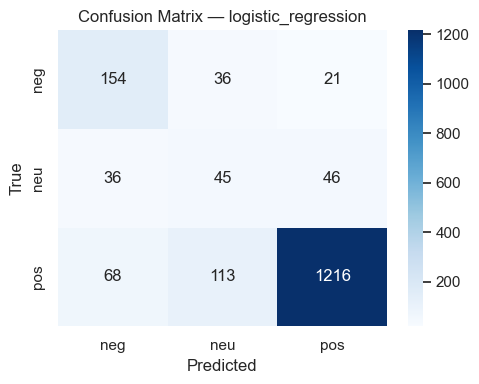

[TABLE] Saved and displaying 'classification_report_linear_svc.csv' from outputs/tables/classification_report_linear_svc.csv
              precision    recall  f1-score     support
negative       0.675127  0.630332  0.651961   211.00000
neutral        0.232323  0.181102  0.203540   127.00000
positive       0.911744  0.939155  0.925247  1397.00000
accuracy       0.846110  0.846110  0.846110     0.84611
macro avg      0.606398  0.583530  0.593582  1735.00000
weighted avg   0.833235  0.846110  0.839183  1735.00000


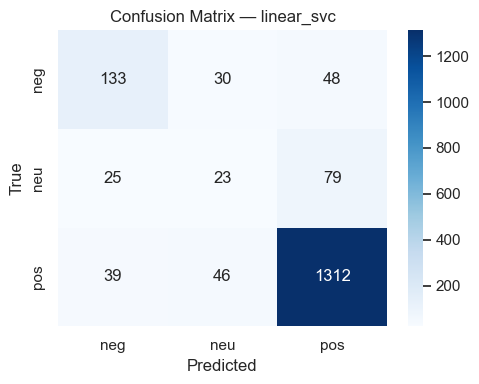

Best-performing model: logistic_regression — {'accuracy': 0.8155619596541787, 'macro_f1': 0.6148509787511043, 'weighted_f1': 0.8310662904604882}
Retraining best model on full dataset...
[TABLE] Saved and displaying 'logistic_top_terms_by_class.csv' from outputs/tables/logistic_top_terms_by_class.csv
      label          type                                              terms
0  negative  top_positive  return, junk, waste, poor, useless, terrible, ...
1  negative  top_negative  great, love, good, price, nice, easy, perfect,...
2   neutral  top_positive  okay, picture, probably, bad, bit, fine, wish,...
3   neutral  top_negative  box, worth, happy, excellent, look like, junk,...
4  positive  top_positive  great, love, excellent, perfect, awesome, easy...
5  positive  top_negative  return, bad, break, poor, send, okay, pay, fal...
[TABLE] Saved and displaying 'supervised_model_metrics.csv' from outputs/tables/supervised_model_metrics.csv
                     accuracy  macro_f1  weighted_f

In [8]:
train_df, test_df = train_test_split(
    df_labeled,
    test_size=0.2,
    stratify=df_labeled["sentiment_label"],
    random_state=SEED,
)
print("Building TF-IDF features...")
vectorizer, X_train, X_test = build_tfidf_features(
    train_df["text_clean"],
    test_df["text_clean"],
)

print("Running baselines...")
baseline_majority = majority_baseline(
    train_df["sentiment_label"],
    test_df["sentiment_label"],
)
baseline_lexicon = lexicon_baseline(
    test_df["text_clean"],
    test_df["sentiment_label"],
)
save_json(
    {
        "majority_baseline": baseline_majority,
        "lexicon_baseline": baseline_lexicon,
    },
    "baseline_metrics.json",
)

print("Training supervised models...")
best_model_name, metrics, _ = train_sentiment_models(
    X_train,
    train_df["sentiment_label"],
    X_test,
    test_df["sentiment_label"],
)

print("Retraining best model on full dataset...")
X_full = vectorizer.fit_transform(df_labeled["text_clean"])
best_model_full = (
    LogisticRegression(
        random_state=SEED,
        max_iter=400,
        class_weight="balanced",
    )
    if best_model_name == "logistic_regression"
    else LinearSVC(random_state=SEED, class_weight="balanced")
)
best_model_full.fit(X_full, df_labeled["sentiment_label"])
df_labeled["sentiment_pred"] = best_model_full.predict(X_full)

if best_model_name == "logistic_regression":
    extract_logistic_top_terms(best_model_full, vectorizer)

save_table(
    pd.DataFrame(metrics).T,
    "supervised_model_metrics.csv",
)

## 4. Topic Modeling & LLM Summaries

In [9]:
def build_topic_model(
    texts: Sequence[str],
    n_topics: int = N_TOPICS,
) -> Tuple[NMF, TfidfVectorizer, np.ndarray]:
    vectorizer = TfidfVectorizer(
        max_features=15_000,
        min_df=5,
        max_df=0.95,
        ngram_range=(1, 2),
    )
    tfidf = vectorizer.fit_transform(texts)
    nmf = NMF(
        n_components=n_topics,
        init="nndsvd",
        max_iter=400,
        random_state=SEED,
        tol=1e-4,
    )
    topic_weights = nmf.fit_transform(tfidf)
    return nmf, vectorizer, topic_weights


def describe_topics(
    nmf_model: NMF,
    vectorizer: TfidfVectorizer,
    texts: pd.Series,
    topic_weights: np.ndarray,
) -> pd.DataFrame:
    feature_names = vectorizer.get_feature_names_out()
    rows = []
    dominant_topics = topic_weights.argmax(axis=1)
    max_scores = topic_weights.max(axis=1)
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[::-1][:TOP_TERMS_PER_TOPIC]]
        mask = dominant_topics == topic_idx
        exemplars = texts[mask]
        exemplar_examples = (
            exemplars.iloc[np.argsort(max_scores[mask])[-TOPIC_EXEMPLARS:]]  # last ones highest
            if mask.sum() >= TOPIC_EXEMPLARS
            else exemplars
        )
        rows.append(
            {
                "topic_id": topic_idx,
                "top_terms": ", ".join(top_features),
                "n_reviews": int(mask.sum()),
                "exemplar_reviews": exemplar_examples.tolist(),
            }
        )
    topic_df = pd.DataFrame(rows)
    save_table(topic_df[["topic_id", "top_terms", "n_reviews"]], "topic_top_terms.csv")
    topic_df_path = (INTERMEDIATE_DIR / "topic_exemplars.json")
    topic_df_path.write_text(topic_df.to_json(orient="records", indent=2), encoding="utf-8")
    return topic_df


def init_llm_client() -> Optional[OpenAI]:
    api_key = os.getenv("XLAB_API_KEY")
    base_url = os.getenv("LLM_BASE_URL")
    model_path = os.getenv("LLM_MODEL_PATH")
    if not all([api_key, base_url, model_path]):
        print(
            "LLM environment variables missing. "
            "Set XLAB_API_KEY, LLM_BASE_URL, and LLM_MODEL_PATH to enable summaries."
        )
        return None
    client = OpenAI(api_key=api_key, base_url=base_url)
    return client


def summarize_topic_with_llm(
    client: OpenAI,
    topic_row: Dict,
    model_path: str,
) -> Tuple[str, str]:
    prompt = (
        "You are analyzing Amazon musical instrument reviews. "
        "Given the top terms and exemplar reviews for a topic, "
        "provide (1) a short topic title and (2) a two-sentence summary "
        "that explains what customers discuss and why it matters.\n\n"
        f"Top terms: {topic_row['top_terms']}\n\n"
        "Exemplar reviews:\n"
    )
    for idx, review in enumerate(topic_row["exemplar_reviews"], start=1):
        prompt += f"{idx}. {review[:500]}\n"

    response = client.chat.completions.create(
        model=model_path,
        temperature=0.2,
        max_tokens=300,
        messages=[
            {"role": "system", "content": "You create precise insights for business audiences."},
            {"role": "user", "content": prompt},
        ],
    )
    content = response.choices[0].message.content.strip()
    parts = content.split("\n", 1)
    if len(parts) == 2:
        title, summary = parts
    else:
        title = parts[0]
        summary = content
    return title.strip(), summary.strip()


def generate_llm_topic_summaries(topic_df: pd.DataFrame) -> pd.DataFrame:
    client = init_llm_client()
    model_path = os.getenv("LLM_MODEL_PATH")
    rows = []
    for _, row in topic_df.iterrows():
        if client:
            title, summary = summarize_topic_with_llm(client, row, model_path)
        else:
            title = f"Topic {row['topic_id']} (LLM disabled)"
            summary = (
                "Set XLAB_API_KEY / LLM_BASE_URL / LLM_MODEL_PATH to enable automated summaries."
            )
        rows.append(
            {
                "topic_id": row["topic_id"],
                "llm_title": title,
                "llm_summary": summary,
            }
        )
    llm_df = pd.DataFrame(rows)
    save_table(llm_df, "topic_llm_summaries.csv")
    return llm_df

### 4.1 Topic modeling and optional LLM summaries

In [10]:
print("Running topic model...")
nmf_model, topic_vectorizer, topic_weights = build_topic_model(df_labeled["text_clean"])
print(
    "Topic weights stats — "
    f"min={topic_weights.min():.4f}, max={topic_weights.max():.4f}, "
    f"mean={topic_weights.mean():.4f}"
)
topic_df = describe_topics(
    nmf_model,
    topic_vectorizer,
    df_labeled["text_original"],
    topic_weights,
)
llm_topic_summaries = generate_llm_topic_summaries(topic_df)

Running topic model...
Topic weights stats — min=0.0000, max=0.3262, mean=0.0116
[TABLE] Saved and displaying 'topic_top_terms.csv' from outputs/tables/topic_top_terms.csv
   topic_id                                          top_terms  n_reviews
0         0  sound, headphone, like, pedal, quality, amp, b...       1827
1         1  star, star great, star good, star work, star n...        614
2         2  work, work great, star work, great, work fine,...        824
3         3  great, star great, product, great product, gre...        784
4         4  guitar, play, pick, tuner, tune, acoustic, gre...        831
5         5  good, star good, good quality, quality, price,...        768
6         6  case, nice, fit, bag, strap, star nice, look, ...       1022
7         7  string, good string, tune, great string, play,...        469
8         8  love, son, gift, daughter, perfect, old, son l...        842
9         9  stand, mic, mic stand, microphone, use, sturdy...        690
[TABLE] Saved 

## 5. Sentiment–Topic Integration & Visualization

In [11]:
def attach_topic_metadata(df: pd.DataFrame, topic_weights: np.ndarray) -> pd.DataFrame:
    df = df.copy()
    df["dominant_topic"] = topic_weights.argmax(axis=1)
    df["dominant_topic_score"] = topic_weights.max(axis=1)
    return df


def summarize_sentiment_by_topic(df: pd.DataFrame) -> pd.DataFrame:
    pivot = (
        df.groupby(["dominant_topic", "sentiment_pred"])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=["negative", "neutral", "positive"])
        .fillna(0)
    )
    pivot["total"] = pivot.sum(axis=1)
    pivot["negative_pct"] = pivot["negative"] / pivot["total"]
    pivot["positive_pct"] = pivot["positive"] / pivot["total"]
    save_table(pivot, "topic_sentiment_distribution.csv")

    pivot_norm = pivot[["negative", "neutral", "positive"]].div(pivot["total"], axis=0)
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot_norm.plot(
        kind="bar",
        stacked=True,
        color=["#d62728", "#ffbf00", "#2ca02c"],
        ax=ax,
    )
    ax.set_ylabel("Share of reviews")
    ax.set_xlabel("Topic ID")
    ax.set_title("Sentiment Distribution by Topic")
    save_and_show_figure(fig, "topic_sentiment_distribution")
    return pivot


def sentiment_trends_by_topic(df: pd.DataFrame, top_n_topics: int = 5) -> pd.DataFrame:
    df = df.copy()
    df["review_month"] = df["review_date"].dt.to_period("M").dt.to_timestamp()
    top_topics = (
        df["dominant_topic"]
        .value_counts()
        .head(top_n_topics)
        .index
    )
    trend_counts = (
        df[df["dominant_topic"].isin(top_topics)]
        .groupby(["review_month", "dominant_topic", "sentiment_pred"])
        .size()
        .rename("count")
        .reset_index()
    )
    trend_counts["share"] = (
        trend_counts.groupby(["review_month", "dominant_topic"])["count"]
        .transform(lambda x: x / x.sum())
    )
    trend = trend_counts
    save_table(trend, "topic_sentiment_trends.csv")

    fig, ax = plt.subplots(figsize=(12, 6))
    for topic_id in top_topics:
        subset = trend[(trend["dominant_topic"] == topic_id) & (trend["sentiment_pred"] == "negative")]
        ax.plot(subset["review_month"], subset["share"], label=f"Topic {topic_id}")
    ax.set_title("Negative Sentiment Share Over Time (Top Topics)")
    ax.set_ylabel("Negative share")
    ax.set_xlabel("Month")
    ax.legend(title="Topic")
    save_and_show_figure(fig, "negative_sentiment_trend_by_topic")
    return trend


def product_level_topic_insights(df: pd.DataFrame, top_n_products: int = 3) -> pd.DataFrame:
    top_products = df["product_id"].value_counts().head(top_n_products).index
    product_topic = (
        df[df["product_id"].isin(top_products)]
        .groupby(["product_id", "dominant_topic", "sentiment_pred"])
        .size()
        .rename("count")
        .reset_index()
    )
    save_table(product_topic, "product_topic_sentiment_counts.csv")
    return product_topic

### 5.1 Integrate sentiment and topic outputs with exports

[TABLE] Saved and displaying 'topic_sentiment_distribution.csv' from outputs/tables/topic_sentiment_distribution.csv
sentiment_pred  negative  neutral  positive  total  negative_pct  positive_pct
dominant_topic                                                                
0                    428      312      1087   1827      0.234264      0.594964
1                    147       92       375    614      0.239414      0.610749
2                    156       99       569    824      0.189320      0.690534
3                     49       35       700    784      0.062500      0.892857
4                     94       79       658    831      0.113117      0.791817
5                     50       94       624    768      0.065104      0.812500
6                    135      123       764   1022      0.132094      0.747554
7                     51       61       357    469      0.108742      0.761194
8                     34       29       779    842      0.040380      0.925178
9             

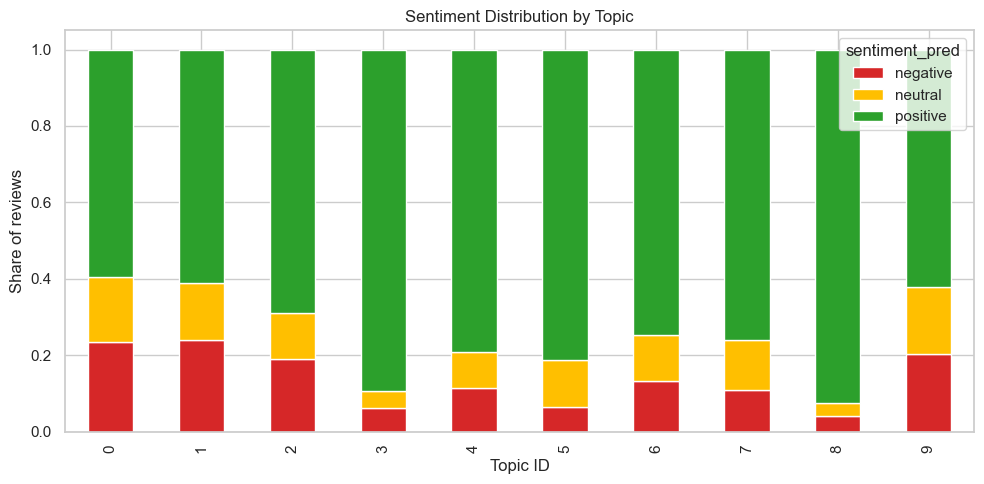

[TABLE] Saved and displaying 'topic_sentiment_trends.csv' from outputs/tables/topic_sentiment_trends.csv
    review_month  dominant_topic sentiment_pred  count     share
0     2000-08-01               0       positive      1  1.000000
1     2001-02-01               0       positive      1  1.000000
2     2001-12-01               6        neutral      1  1.000000
3     2002-10-01               0       positive      1  1.000000
4     2003-05-01               0        neutral      1  1.000000
5     2003-12-01               0        neutral      1  0.500000
6     2003-12-01               0       positive      1  0.500000
7     2004-08-01               6       negative      1  1.000000
8     2004-09-01               4       positive      1  1.000000
9     2004-09-01               8       positive      1  1.000000
10    2004-10-01               0        neutral      1  1.000000
11    2004-11-01               0       negative      1  1.000000
12    2004-12-01               8       positive   

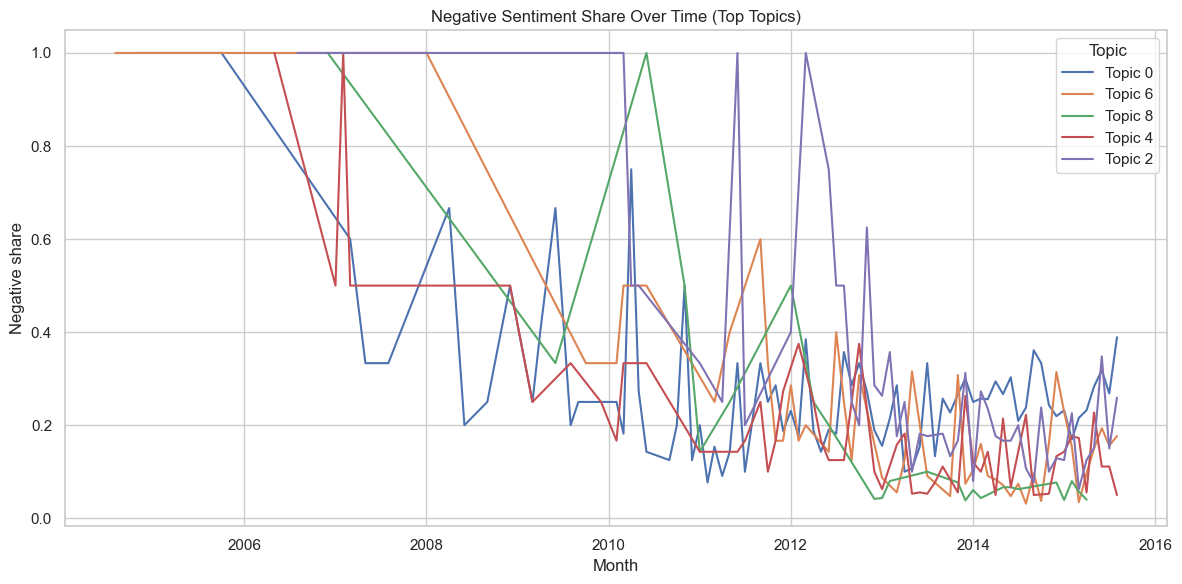

[TABLE] Saved and displaying 'product_topic_sentiment_counts.csv' from outputs/tables/product_topic_sentiment_counts.csv
    product_id  dominant_topic sentiment_pred  count
0   B000065BPB               0       negative      2
1   B000065BPB               0        neutral      3
2   B000065BPB               0       positive      7
3   B000065BPB               2       positive      1
4   B000065BPB               3       positive      1
5   B000065BPB               5        neutral      1
6   B000065BPB               5       positive      2
7   B000065BPB               6        neutral      1
8   B000065BPB               6       positive      2
9   B000065BPB               8       positive      3
10  B000ULAP4U               0       negative      2
11  B000ULAP4U               0        neutral      4
12  B000ULAP4U               0       positive     17
13  B000ULAP4U               3        neutral      1
14  B000ULAP4U               5       positive      1
15  B000ULAP4U               6 

In [12]:
df_topics = attach_topic_metadata(df_labeled, topic_weights)
summarize_sentiment_by_topic(df_topics)
sentiment_trends_by_topic(df_topics)
product_level_topic_insights(df_topics)

save_table(
    df_topics[
        [
            "review_id",
            "product_id",
            "star_rating",
            "sentiment_pred",
            "dominant_topic",
            "dominant_topic_score",
        ]
    ],
    "review_sentiment_topic_assignments.csv",
)
print("Pipeline completed. Outputs saved to the 'outputs/' directory.")